<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/Application/Classification_automation_SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The objectives of this notebook are:

+ Conduct scientific literature searches on [Semantic Scholar](https://www.semanticscholar.org/) utilizing the [S2Query](https://github.com/BecomeAllan/S2Query) package.
+ Utilizing the [ML-SLCR](https://github.com/BecomeAllan/ML-SLRC/blob/main/Meta_learning_EFL.ipynb) model to include/exclude articles from a systematic literature review.

# Dependencies required


In [ ]:
!pip install S2query
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!git lfs install
!git clone https://huggingface.co/becomeallan/ML-SLRC
!pip install crossrefapi

# !pip install matplotlib==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 880 kB 47.8 MB/s 
     |████████████████████████████████| 6.6 MB 27.2 MB/s 
     |████████████████████████████████| 86 kB 1.4 MB/s 
     |████████████████████████████████| 596 kB 51.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=63f2bcdee87651cf0b96a9ab7d2fc57974e12e89709966aebd54197e1be8be33
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.de

In [ ]:
from itertools import chain
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import HTML, display, clear_output, Markdown

%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path
from crossref.restful import Works


import sys

sys.path.append("/content/ML-SLRC/")

path = "/content/ML-SLRC/"

model_path = path + "model.pt"
info_path = path + "Info.json"


from Util_funs import train_loop, prepare_data, SLR_Classifier, Encoder, SLR_DataSet

# Kind of device to utilize the model on  (GPU, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the model
model = torch.load(model_path)

# Loading meta info of the trained model
with open(info_path, "r") as f:
    Info = json.load(f)

# Configuring some of the meta info
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info["model"], do_lower_case=True)
Info["threshold"] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

# Semantic Scholar Query

In order to conduct the literature search, two functions can be used:

+ `SearcherAPI`: Searches through the Semantic Scholar API.
+ `SearcherWeb`: Searches by scraping the Semantic Scholar website.

Within the search functions, keywords must be specified utilizing single quotation marks: `'keyword'`. Additionally, `+` and `-` signs can be used to include and exclude keywords from the search.

Example: `'artificial intelligence' + 'Deep Learning' - 'Biology'`



## Using the API to search for data

Within the available parameters:

+ `Query`: Search words such as titles or keywords
+ `Number of papers`: Number of results to be returned, as many as 10,000.

Upon providing these parameters, use the `Search` button to conduct the search. Once it's finished, the `Export Articles` and `Export All` buttons will save the data, considering scientific articles only or all fetched data, respectively.

+ `Export Articles` saves as .csv: `data_API_Articles.csv`.
+ `Export All` saves as .csv: `data_API.csv`.

In [ ]:
# @title SearcherAPI
from S2query import S2paperAPI
from multiprocessing import Pool

# Search interface using SS API
class SearcherAPI:
    def __init__(self):
        # Creates data fetching object
        self.obj = S2paperAPI()
        self.find = False
        self.save_b = widgets.Button(description="Export Articles")
        self.save_b.on_click(self.post_processing)
        self.save_all_b = widgets.Button(description="Export All")
        self.save_all_b.on_click(self.save_data)

        # Creating buttons and textbox
        self.search_b = widgets.Button(description="Search")
        self.search_text = widgets.Textarea(
            description=":Query",
            value="'artificial intelligence' + 'Deep Learning' - 'Biology'",
            placeholder="Type something",
            layout=Layout(
                width="50%", height="60px", display="flex", flex_flow="row-reverse"
            ),
            # description=':',
            disabled=False,
        )

        self.number_papers = widgets.IntText(
            value=100,
            min=2,
            # layout = widgets.Layout(width='180px'),
            style={"description_width": "initial"},
            layout=Layout(width="180px", display="flex", flex_flow="row-reverse"),
            description=" Number of papers",
            disabled=False,
        )

        # self.leftbox = widgets.HBox([self.search_text])
        self.rightbox = widgets.VBox(
            [self.search_text, self.number_papers, self.search_b]
        )

        # self.hbox = widgets.HBox([self.leftbox, self.rightbox])
        self.save_h = widgets.HBox([self.save_b, self.save_all_b])

        # On click function
        self.search_b.on_click(self.search_button)

    # Search button
    def search_button(self, p):
        print(self.search_text.value)
        # Searches data
        self.obj.get(
            self.search_text.value,
            n=self.number_papers.value,
            fields = ['externalIds', 'paperId', 'url', 'title', \
                        'abstract', 'venue', 'year', 'referenceCount', \
                        'citationCount', 'influentialCitationCount', \
                        'isOpenAccess', 'fieldsOfStudy', 'authors']
        )

        # Saves data found
        self.data = self.obj.all

        # self.data

        self.find = True
        self.__call__()

    def post_processing(self, p):
        self.data = self.data.rename(columns={"externalIds": "doi"})
        doi = [d.get("DOI") for d in self.data.doi]
        self.data["doi"] = doi
        null = self.data.doi.isnull().values
        self.data = self.data.drop(self.data[null].index)
        self.data = self.data[self.data.doi != ""]

        self.works = Works()
        docs_type = []

        dois = self.data.doi.to_list()

        # with Pool(2) as p:
        #   docs_type = p.map(self.multiprocessing, dois)

        print("processing ...")

        for doi in dois:
            try:
                t = self.works.doi(doi)["type"]
            except:
                t = ""
            docs_type.append(t)

        self.data["type"] = docs_type
        mask = ["journal-article", "proceedings-article"]
        self.data_article = self.data[self.data["type"].isin(mask)]
        self.data_article = self.data_article.reset_index().drop("index", axis=1)
        self.data_article.to_csv("data_API_Articles.csv")
        self.__call__()
        print("Saved as data_API_Articles.csv")

    def save_data(self, p):
        self.data.to_csv("data_API.csv")
        self.__call__()
        print("Saved as data_API.csv")

    def multiprocessing(self, data):
        try:
            t = self.works.doi(data)["type"]
        except:
            t = ""

        return t

    # Call function
    def __call__(self):
        clear_output()
        # Displaying buttons
        display(self.rightbox)
        if self.find:
            display(self.save_h)


In [ ]:
resultAPI = SearcherAPI()
resultAPI()

Saved as data_API_Articles.csv


## Using the SS website to search for data

Besides the keywords text box, the following parameters are available:

+ `Number of papers`: Number of papers to be returned.
+ `Sort by`: Sorting criteria for results.
+ `min./max year`: Year of publication.
+ `venue`: Publication venue.
+ `Publication`: Kind of publication (JournalArticle is recommended).
+ `fieldsOfStudy`: Fields of study.

Upon providing these parameters, use the `Search` button to conduct the search. Once it's finished, the `Export Data` button will save all results as .csv: `data_API.csv`

In [ ]:
# @title Data classifying and model training functions

from scipy import stats
import matplotlib.patches as mpatches

from ipywidgets import GridspecLayout
from scipy.stats import poisson


class Judger:
    def __init__(self, data, configure_text=True):
        self.data = data
        self.selected_indx = []
        self.index = 0

        # Density distribution to sample for labeling
        density = poisson.pmf(range(len(self.data)), mu=10)

        # Randomizing indexes
        self.shuffle = np.random.choice(
            range(len(data)), p=density, replace=False, size=len(data)
        )

        if configure_text:
            # Creating 'text' column uniting title and abstract
            self.data.fillna(value="", inplace=True)
            self.data["text"] = self.data["title"] + ". " + self.data["abstract"]

            self.data

        if any(self.data.isin(["label"])):
            self.data["label"] = self.data["label"].replace(
                {
                    "negative": "Not Included",
                    "0": "Not Included",
                    "excluded": "Not Included",
                    0: "Not Included",
                    1: "Included",
                    "1": "Included",
                    "positive": "Included",
                }
            )
            ok = 1
        else:
            self.data["label"] = np.nan

        # Buttons
        self.next_b = widgets.Button(description="Next")
        self.previous_b = widgets.Button(description="Previous")
        self.Included = widgets.Button(description="Included")
        self.NIncluded = widgets.Button(description="Not Included")
        self.erase_b = widgets.Button(description="Erase")

        # On click functions
        self.next_b.on_click(self.next_button)
        self.previous_b.on_click(self.prev_button)
        self.Included.on_click(self.Included_button)
        self.NIncluded.on_click(self.Not_Included_button)
        self.erase_b.on_click(self.erase_button)

        # Button placement configuration
        self.Judger_hbox1 = widgets.HBox([self.NIncluded, self.Included])
        self.Judger_hbox2 = widgets.HBox([self.previous_b, self.next_b, self.erase_b])
        self.Judger_grid = widgets.VBox([self.Judger_hbox1, self.Judger_hbox2])

    # Include in review button
    def Included_button(self, p):
        self.data.loc[self.shuffle[self.index], "label"] = "Included"
        self.index += 1
        self.__call__()

    # Exclude from review button
    def Not_Included_button(self, p):
        self.data.loc[self.shuffle[self.index], "label"] = "Not Included"
        self.index += 1
        self.__call__()

    # Erase label button
    def erase_button(self, p):
        text = self.data.loc[self.shuffle[self.index], "text"]
        self.data.loc[self.shuffle[self.index], "label"] = np.nan

        self.__call__()

    # Next button
    def next_button(self, p):
        # Checks if it's possible to go to the next text
        try:
            self.index += 1
            text = self.data.loc[self.shuffle[self.index], "text"]
        except:
            self.index = 0
        self.__call__()

    # Prev button
    def prev_button(self, p):
        # Checks if it's possible to go to the previous text
        if self.index - 1 < 0:
            self.index = len(self.data) - 1
        else:
            self.index -= 1

        self.__call__()

    # Call function
    def __call__(self):
        clear_output()
        # Unlabeled data
        criteria_na = self.data["label"].isna()

        # If all data is labeled
        # if sum(criteria_na) == 0 or self.index > len(self.data):
        # return print('Finished')

        # Random index to pick an article to be classified
        indexs_unlabeled = self.data.loc[criteria_na].index

        # Saving chosen index
        self.selected_indx.append(self.index)

        # Text and label for this index
        text = self.data.loc[self.shuffle[self.index], "text"]
        label = self.data.loc[self.shuffle[self.index], "label"]

        statistics = self.data["label"].value_counts()

        try:
            neg = statistics["Not Included"]
        except:
            neg = 0
        try:
            pos = statistics["Included"]
        except:
            pos = 0

        self.pos = pos
        self.neg = neg

        # Printing some results
        print(f"Current example: {self.index+1} / {len(self.data)}")
        print(f"Unlabeled: {sum(criteria_na)}")
        print(f"Not included examples: {neg} | Included examples: {pos}")

        display(self.Judger_grid)
        print("Text:")
        display(Markdown(text))
        print("Label:", label)


class Train:
    def __init__(self, model, data, device, Info):
        self.data = data
        self.model = model
        self.Info = Info
        self.device = device
        self.trained = False
        self.index = 0

        # Buttons
        self.train_b = widgets.Button(description="Train")
        self.number_class = widgets.IntText(
            value=2,
            min=2,
            layout=widgets.Layout(width="150px"),
            style={"description_width": "initial"},
            description="Size per class:",
            disabled=False,
        )
        self.value_trash = widgets.FloatText(
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            description="Confidence Level:",
            layout=widgets.Layout(width="170px"),
            style={"description_width": "initial"},
            disabled=False,
        )

        # Button placement configuration
        self.Train_hbox = widgets.HBox(
            [self.train_b, self.number_class, self.value_trash]
        )

        # On click functions
        self.train_b.on_click(self.train_button)
        self.treshold = self.value_trash.value

    # Train button
    def train_button(self, p):
        clear_output()
        print("Training...")
        # Pre-processing text data before feeding to model
        test_batch_size = 100 if len(self.data) > 100 else len(self.data)

        try:
            (
                self.data_train_loader,
                self.data_test_loader,
                self.data_train,
                self.data_test,
            ) = prepare_data(
                self.data,
                train_size_per_class=self.number_class.value,
                batch_size={
                    "train": self.Info["inner_batch_size"],
                    "test": test_batch_size,
                },
                max_seq_length=self.Info["max_seq_length"],
                tokenizer=self.Info["tokenizer"],
                input="text",
                output="label",
            )

        except:
            self.__call__()
            print("Try another size per class")
            return

        # Trains model and gets classifier layer vector
        self.logits = train_loop(
            self.data_train_loader,
            self.data_test_loader,
            self.model,
            self.device,
            epoch=self.Info["inner_update_step"],
            lr=self.Info["inner_update_lr"],
            print_info=True,
            name="test",
        )

        # Sigmoid to assert predictions to 0 and 1
        predictions = torch.sigmoid(self.logits)

        # Saving predictions for test data
        self.data_test["prediction"] = predictions
        self.data = self.data_test

        self.trained = True
        self.__call__()
        print("Done")

    def __call__(self):
        display(self.Train_hbox)


class Interface(Judger, Train):
    def __init__(self, data):
        Judger.__init__(self, data)
        Train.__init__(self, model, self.data, device, Info)

        # Buttons
        self.avaliation_b = widgets.Button(description="Avaliation")
        self.export_b = widgets.Button(description="Export data")
        self.reord_b = widgets.Button(description="Reorder data")

        # On click functions
        self.avaliation_b.on_click(self.avaliation_button)
        self.export_b.on_click(self.export_button)
        self.reord_b.on_click(self.model_order_button)

        # Button placement configuration
        self.avaliate = widgets.HBox([self.export_b, self.avaliation_b, self.reord_b])

    # Reordering data
    def model_order_button(self, p):
        kernel = stats.gaussian_kde(self.data["prediction"])
        prob = 1 / kernel(self.data["prediction"])
        prob = prob / sum(prob)
        self.shuffle = np.random.choice(
            range(len(self.data)), size=len(self.data), replace=False, p=prob
        )
        self.__call__()

    # Evaluating data distribution
    def avaliation_button(self, p):

        self.treshold = self.value_trash.value

        _, _, bars = plt.hist(self.data["prediction"], color="C0")

        for bar in bars:
            if bar.get_x() > self.treshold:
                bar.set_facecolor("C1")
        plt.title("Number of papers by Confidence level")
        plt.xlabel("Confidence level")
        plt.ylabel("Number of papers")

        n_incl = sum(self.data["prediction"] >= self.treshold)
        n_notincl = sum(self.data["prediction"] < self.treshold)

        Inc = mpatches.Patch(color="C1", label=f"(Model) Included: {n_incl}")
        notInc = mpatches.Patch(color="C0", label=f"(Model) Not Included: {n_notincl}")

        plt.legend(handles=[Inc, notInc])
        plt.axvline(self.treshold, color="red", linestyle="dashed", linewidth=1)
        self.__call__()

        plt.show()

    # Saving data
    def export_button(self, p):
        data = self.data
        data["model_label"] = (data["prediction"] > self.treshold) * 1
        data = data.rename(columns={"prediction": "confidence"})
        data.to_csv("data.csv")

        self.__call__()
        print("Saved as data.csv")

    # Call function
    def __call__(self):
        Judger.__call__(self)

        if (self.pos >= 2) & (self.neg >= 2):
            if self.trained:
                prediction = self.data.loc[self.shuffle[self.index], "prediction"]
                # Displaying some results
                print("Confidence:", prediction)
                print("(Model) Included:", self.treshold <= prediction)
                display(self.avaliate)

            Train.__call__(self)


In [ ]:
resultWEB = SearcherWeb()
resultWEB()

Button(description='Export Data', style=ButtonStyle())

Saved as data_WEB.csv


In [ ]:
resultWEB.data.head(2)

,title,year,entities,fieldsOfStudy,abstract,numReferences,numCitations,link
0,Artificial intelligence: Deep learning in onco...,2021,[],[Computer Science],,118,19,https://www.ncbi.nlm.nih.gov/pubmed/33765601
1,Unraveling the deep learning gearbox in optica...,2021,[],[Computer Science],Machine learning has greatly facilitated the a...,120,4,https://doi.org/10.1038/s42003-021-01697-y


# Training the model on labeling

In [ ]:
# @title Data classifying and model training functions

from scipy import stats
import matplotlib.patches as mpatches

from ipywidgets import GridspecLayout
from scipy.stats import poisson


class Judger:
    def __init__(self, data, configure_text=True):
        self.data = data
        self.selected_indx = []
        self.index = 0

        # Density distribution to sample for labeling
        density = poisson.pmf(range(len(self.data)), mu=10)

        # Randomizing indexes
        self.shuffle = np.random.choice(
            range(len(data)), p=density, replace=False, size=len(data)
        )

        if configure_text:
            # Creating 'text' column uniting title and abstract
            self.data.fillna(value="", inplace=True)
            self.data["text"] = self.data["title"] + ". " + self.data["abstract"]

            self.data

        if any(self.data.isin(["label"])):
            self.data["label"] = self.data["label"].replace(
                {
                    "negative": "Not Included",
                    "0": "Not Included",
                    "excluded": "Not Included",
                    0: "Not Included",
                    1: "Included",
                    "1": "Included",
                    "positive": "Included",
                }
            )
            ok = 1
        else:
            self.data["label"] = np.nan

        # Buttons
        self.next_b = widgets.Button(description="Next")
        self.previous_b = widgets.Button(description="Previous")
        self.Included = widgets.Button(description="Included")
        self.NIncluded = widgets.Button(description="Not Included")
        self.erase_b = widgets.Button(description="Erase")

        # On click functions
        self.next_b.on_click(self.next_button)
        self.previous_b.on_click(self.prev_button)
        self.Included.on_click(self.Included_button)
        self.NIncluded.on_click(self.Not_Included_button)
        self.erase_b.on_click(self.erase_button)

        # Button placement configuration
        self.Judger_hbox1 = widgets.HBox([self.NIncluded, self.Included])
        self.Judger_hbox2 = widgets.HBox([self.previous_b, self.next_b, self.erase_b])
        self.Judger_grid = widgets.VBox([self.Judger_hbox1, self.Judger_hbox2])

    # Include in review button
    def Included_button(self, p):
        self.data.loc[self.shuffle[self.index], "label"] = "Included"
        self.index += 1
        self.__call__()

    # Exclude from review button
    def Not_Included_button(self, p):
        self.data.loc[self.shuffle[self.index], "label"] = "Not Included"
        self.index += 1
        self.__call__()

    # Erase label button
    def erase_button(self, p):
        text = self.data.loc[self.shuffle[self.index], "text"]
        self.data.loc[self.shuffle[self.index], "label"] = np.nan

        self.__call__()

    # Next button
    def next_button(self, p):
        # Checks if it's possible to go to the next text
        try:
            self.index += 1
            text = self.data.loc[self.shuffle[self.index], "text"]
        except:
            self.index = 0
        self.__call__()

    # Prev button
    def prev_button(self, p):
        # Checks if it's possible to go to the previous text
        if self.index - 1 < 0:
            self.index = len(self.data) - 1
        else:
            self.index -= 1

        self.__call__()

    # Call function
    def __call__(self):
        clear_output()
        # Unlabeled data
        criteria_na = self.data["label"].isna()

        # If all data is labeled
        # if sum(criteria_na) == 0 or self.index > len(self.data):
        # return print('Finished')

        # Random index to pick an article to be classified
        indexs_unlabeled = self.data.loc[criteria_na].index

        # Saving chosen index
        self.selected_indx.append(self.index)

        # Text and label for this index
        text = self.data.loc[self.shuffle[self.index], "text"]
        label = self.data.loc[self.shuffle[self.index], "label"]

        statistics = self.data["label"].value_counts()

        try:
            neg = statistics["Not Included"]
        except:
            neg = 0
        try:
            pos = statistics["Included"]
        except:
            pos = 0

        self.pos = pos
        self.neg = neg

        # Printing some results
        print(f"Current example: {self.index+1} / {len(self.data)}")
        print(f"Unlabeled: {sum(criteria_na)}")
        print(f"Not included examples: {neg} | Included examples: {pos}")

        display(self.Judger_grid)
        print("Text:")
        display(Markdown(text))
        print("Label:", label)


class Train:
    def __init__(self, model, data, device, Info):
        self.data = data
        self.model = model
        self.Info = Info
        self.device = device
        self.trained = False
        self.index = 0

        # Buttons
        self.train_b = widgets.Button(description="Train")
        self.number_class = widgets.IntText(
            value=2,
            min=2,
            layout=widgets.Layout(width="150px"),
            style={"description_width": "initial"},
            description="Size per class:",
            disabled=False,
        )
        self.value_trash = widgets.FloatText(
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            description="Confidence Level:",
            layout=widgets.Layout(width="170px"),
            style={"description_width": "initial"},
            disabled=False,
        )

        # Button placement configuration
        self.Train_hbox = widgets.HBox(
            [self.train_b, self.number_class, self.value_trash]
        )

        # On click functions
        self.train_b.on_click(self.train_button)
        self.treshold = self.value_trash.value

    # Train button
    def train_button(self, p):
        clear_output()
        print("Training...")
        # Pre-processing text data before feeding to model
        test_batch_size = 100 if len(self.data) > 100 else len(self.data)

        try:
            (
                self.data_train_loader,
                self.data_test_loader,
                self.data_train,
                self.data_test,
            ) = prepare_data(
                self.data,
                train_size_per_class=self.number_class.value,
                batch_size={
                    "train": self.Info["inner_batch_size"],
                    "test": test_batch_size,
                },
                max_seq_length=self.Info["max_seq_length"],
                tokenizer=self.Info["tokenizer"],
                input="text",
                output="label",
            )

        except:
            self.__call__()
            print("Try another size per class")
            return

        # Trains model and gets classifier layer vector
        self.logits = train_loop(
            self.data_train_loader,
            self.data_test_loader,
            self.model,
            self.device,
            epoch=self.Info["inner_update_step"],
            lr=self.Info["inner_update_lr"],
            print_info=True,
            name="test",
        )

        # Sigmoid to assert predictions to 0 and 1
        predictions = torch.sigmoid(self.logits)

        # Saving predictions for test data
        self.data_test["prediction"] = predictions
        self.data = self.data_test

        self.trained = True
        self.__call__()
        print("Done")

    def __call__(self):
        display(self.Train_hbox)


class Interface(Judger, Train):
    def __init__(self, data):
        Judger.__init__(self, data)
        Train.__init__(self, model, self.data, device, Info)

        # Buttons
        self.evaluation_b = widgets.Button(description="Evaluation")
        self.export_b = widgets.Button(description="Export data")
        self.reord_b = widgets.Button(description="Reorder data")

        # On click functions
        self.evaluation_b.on_click(self.evaluation_button)
        self.export_b.on_click(self.export_button)
        self.reord_b.on_click(self.model_order_button)

        # Button placement configuration
        self.evaluate = widgets.HBox([self.export_b, self.evaluation_b, self.reord_b])

    # Reordering data
    def model_order_button(self, p):
        kernel = stats.gaussian_kde(self.data["prediction"])
        prob = 1 / kernel(self.data["prediction"])
        prob = prob / sum(prob)
        self.shuffle = np.random.choice(
            range(len(self.data)), size=len(self.data), replace=False, p=prob
        )
        self.__call__()

    # Evaluating data distribution
    def evaluation_button(self, p):

        self.treshold = self.value_trash.value

        _, _, bars = plt.hist(self.data["prediction"], color="C0")

        for bar in bars:
            if bar.get_x() > self.treshold:
                bar.set_facecolor("C1")
        plt.title("Number of papers by Confidence level")
        plt.xlabel("Confidence level")
        plt.ylabel("Number of papers")

        n_incl = sum(self.data["prediction"] >= self.treshold)
        n_notincl = sum(self.data["prediction"] < self.treshold)

        Inc = mpatches.Patch(color="C1", label=f"(Model) Included: {n_incl}")
        notInc = mpatches.Patch(color="C0", label=f"(Model) Not Included: {n_notincl}")

        plt.legend(handles=[Inc, notInc])
        plt.axvline(self.treshold, color="red", linestyle="dashed", linewidth=1)
        self.__call__()

        plt.show()

    # Saving data
    def export_button(self, p):
        data = self.data
        data["model_label"] = (data["prediction"] > self.treshold) * 1
        data = data.rename(columns={"prediction": "confidence"})
        data.to_csv("data.csv")

        self.__call__()
        print("Saved as data.csv")

    # Call function
    def __call__(self):
        Judger.__call__(self)

        if (self.pos >= 2) & (self.neg >= 2):
            if self.trained:
                prediction = self.data.loc[self.shuffle[self.index], "prediction"]
                # Displaying some results
                print("Confidence:", prediction)
                print("(Model) Included:", self.treshold <= prediction)
                display(self.evaluate)

            Train.__call__(self)


In order to use the model, it's necessary to conduct a first labeling round. For that, we have the following interface:

+ `Not Included`: Labels example as not included.
+ `Included`: Labels example as included.
+ `Previous`: Returns to previous example.
+ `Next`: Advances to next example.

The `Label` refers to `Text`, which is the concatenation of an article's title and abstract. To use the `Interface()` object, instance the object by passing data in `pandas.DataFrame` format, in which the `title` e `abstract` column must exist. Should the data altready be labeled, the labels must be in a `label` column, containing the following classifiers:

+ For included examples: "Included", "positive" or 1.
+ For not included examples: "Not Included", "excluded", "negative" or 0.

After obtaining **2 included** and **2 not included** examples, the `Train` button will become available. The following configurations can be made:

+ `Size per class`: Number of examples per label
+ `Confidence Level`: Lowest confidence in which the model will classify as included, from 0 to 1.

Upon pressing `Train`, the model will be trained and used to label the data, and the following descriptors will be returned:

+ `Confidence`: Confidence attained by the model on whether to include or exclude an example.
+ `(Model) Included`: Label asserted by the model, based on the `Confidence Level` chosen.

After training the model, a few buttons for prediction evaluation will become available:

+ `Export data`: Exporting data based on `Interface(data)` with the `confidence`, `label` and `model_label` columns added, in which labels **1** and **0** identify inclusion and exclusion, respectively.
+ `Evaluation`: Creates a histogram of examples per confidence interval (`Confidence`), with a vertical line displaying the `Confidence Level`. Distributions close to 1 and 0 are expected, with 0 outnumbering 1.
+ `Reorder data`: Resamples data based on `confidence` and returns a new order of examples, to evaluate `text` data individually.

After training the model, it's possible to change labels, correcting or confirming the model's prediction, as a new training round. We recommend 8 or more examples per label for better model performance.

Current example: 5 / 100
Unlabeled: 96
Not included examples: 2 | Included examples: 2


Text:


Deep learning for biology. A popular artificial-intelligence method provides a powerful tool for surveying and classifying biological data. But for the uninitiated, the technology poses significant difficulties. A popular artificial-intelligence method provides a powerful tool for surveying and classifying biological data. But for the uninitiated, the technology poses significant difficulties.

Label: nan
Confidence: 0.7315929
(Model) Included: True


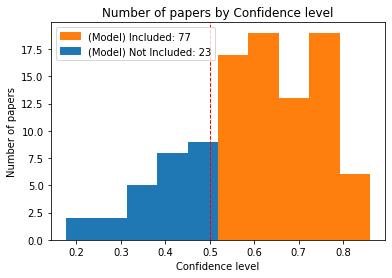

In [ ]:
interface = Interface(resultWEB.data)
interface()

Current example: 5 / 35
Unlabeled: 31
Not included examples: 2 | Included examples: 2


Text:


Deep learning-enhanced light-field imaging with continuous validation. 

Label: nan
Confidence: 0.76386094
(Model) Included: True


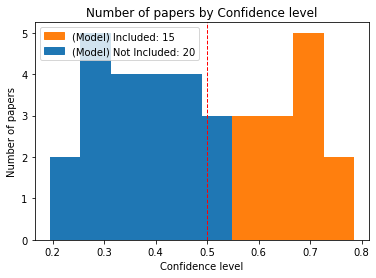

In [ ]:
interface = Interface(resultAPI.data_article)
interface()